<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px">


<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Introduction au Deep Learning avec Keras</h1></center>
<center><h2>Transfer Learning</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


## Contexte et objectif

> Dans les exercices précedents, nous nous sommes essentiellement intéressé à classifier les chiffres manuscrits. Nous avons pu remarquer qu'un algorithme classique comme un **SVM** ou un **RandomForest** nous donnait une estimation proche de la réalitée. Ce n'est plus le cas pour des problèmes de classification plus complexes (ex : classifier des images de chats ou de chiens).
>
>Dans cet exercice, nous allons travailler sur des images de tableau publié sur Kaggle. Le jeu de données sous forme de CSV comprend le chemin de l'image du tableau et le nom du peintre.
>
><img src ="https://datascientest.fr/train/assets/python_keras_picasso_aubade.jpg" style = "width:400px">
>
>L'objectif de cet exercice est d'avoir un aperçu plus large du *transfer learning* et des possibilités du Deep Learning. Nous allons effectuer dans un premier temps une exploration des données. Puis, nous allons utiliser un modèle convolutionnel déjà pré-entrainé avec le jeu de données **imageNet**. Dans la conclusion de l'exercice, nous allons tester un modèle hybride combinant une partie du modèle convolutionnel précédent (extraction de caractéristiques) et un SVM (classification).

## Compétences requises

> * Scikit-learn
> * Matplotlib ou Seaborn
> * Pandas pour la Data Science

* Exécutez la cellule ci-dessous pour importer les modules nécessaires à l'exercice.

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K

Using TensorFlow backend.


## Exploration des données

* Importer le fichier *artists.csv* dans un DataFrame appelé **`artists`**
* Afficher les 5 premières valeurs.

* Afficher le **nombre de peintres** en fonction de leur nationnalité sous forme d'un graphique en barre.

* Afficher le **nombre de tableau** en fonction de la nationalité des peintres sous forme d'un graphique en barre.

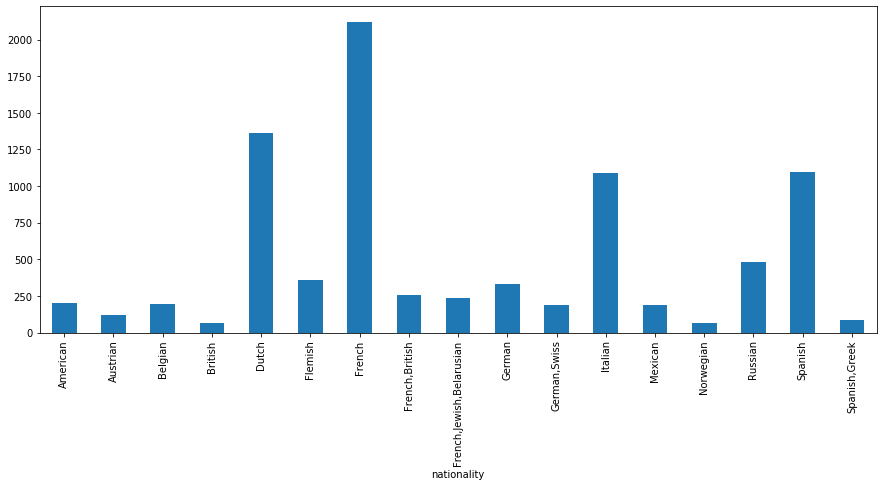

In [4]:
plt.figure(figsize=(15,6))
df2 = artists.groupby("nationality").sum()
df2["paintings"].plot.bar();


* Importer le fichier <strong>file.csv</strong> dans un DataFrame appelé <strong>df</strong>.
* Afficher les 5 premières valeurs.

In [5]:
df = pd.read_csv('file.csv')
df.head()



,img_paths,artists,class
0,images/Albrecht_Durer/Albrecht_Durer_1.jpg,Albrecht_Durer,0
1,images/Albrecht_Durer/Albrecht_Durer_10.jpg,Albrecht_Durer,0
2,images/Albrecht_Durer/Albrecht_Durer_100.jpg,Albrecht_Durer,0
3,images/Albrecht_Durer/Albrecht_Durer_101.jpg,Albrecht_Durer,0
4,images/Albrecht_Durer/Albrecht_Durer_102.jpg,Albrecht_Durer,0


In [ ]:
df = pd.read_csv("file.csv")
df.head()

* Afficher le **nombre de tableau** en fonction du peintre sous forme de graphique en barre.

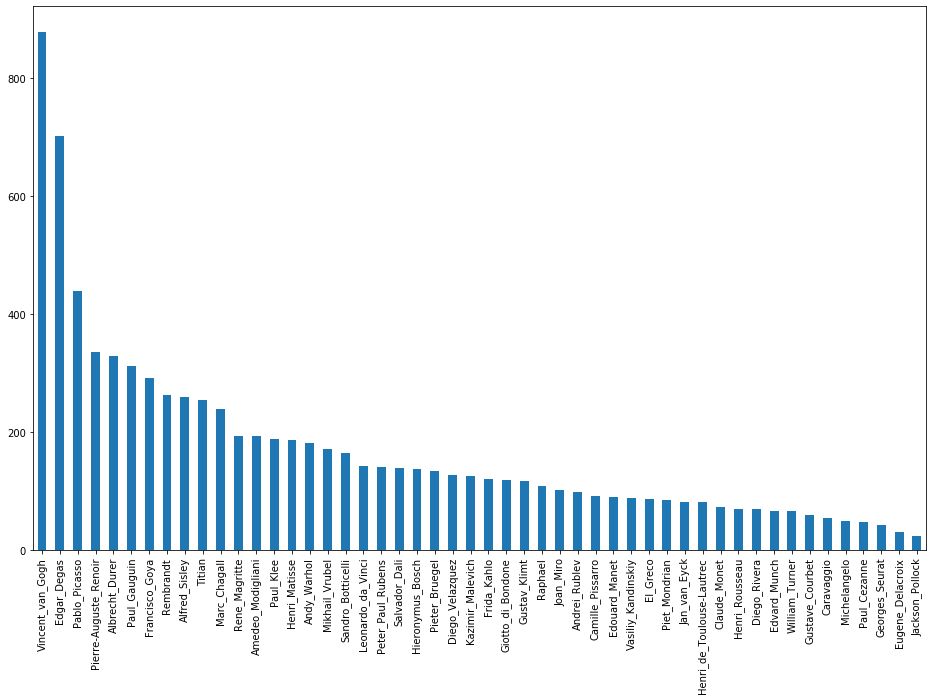

In [6]:
plt.figure(figsize=(16,10))
df["artists"].value_counts().plot.bar();




In [ ]:
plt.figure(figsize=(16,10))
df["artists"].value_counts().plot.bar();

> Pour une question de puissance de calcule, nous n'allons que prendre les 10 premiers peintres du jeu de données.

* Définir un nouveau dataframe sous le nom **data** ne prenant que les **10 premières classes**.
* Séparer le jeu de données **df** en un ensemble d'entraînement **data_train** et en un ensemble de test **data_test**. Nous choisirons un rapport de 80% pour les données d'entraînements. 

In [7]:
n_class = 10
data = df[df["class"].isin(range(n_class))]
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)



In [ ]:
n_class = 10
data = df[df["class"].isin(range(n_class))]
data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center" > Générateur de données </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

> L'un des meilleurs moyens d'améliorer la performance d'un modèle de Deeplearning consiste à ajouter davantage de données à l'ensemble d'entraînement. **Dans le cadre des images**, la génération de nouvelles données peuvent être faite en appliquant des transformations géométriques sur nos images (zoom, rotation, redimensionnement, changement de la luminosité ...) originales.
>
><img src="https://datascientest.fr/train/assets/python_keras_picasso_augmentation.png" style="width:700px">
>
> Les générateurs de données permettent de charger les images lorsque le réseau en a besoin, et de leur appliquer des transformations différentes (rotation, zoom, décalage, ...) pour chaque iteration. Cette approche permet d'augmenter notre jeu de données et d'éviter au maximum le sur-apprentissage.
>
>La fonction [`ImageDataGenerator`](https://keras.io/preprocessing/image/)  de la classe **keras.preprocessing.image** génère des lots de données d’images avec une augmentation des données en temps réel (transformation). Cette fonction a notamment comme arguments :
>>* **preprocessing_function**: la fonction sera exécutée une fois l'image redimensionnée et augmentée. Elle va permettre de prétraiter les images.
>>* **rotation_range**: Plage de degrés pour la rotation aléatoire de l'image.
>>* **width_shift_range**: plage pour la translation horizontale de l'image. Si l'argument est inférieur à 1, l'unité de la plage est une fraction de la largeur de l'image. Sinon, l'unité est en pixel.
>>* **height_shift_range**: plage pour la translation verticale de l'image. Si l'argument est inférieur à 1, l'unité de la plage est une fraction de la largeur de l'image. Sinon, l'unité est en pixel.
>>* **brightness_range**: Tuple ou liste de deux floats. Plage de sélection d'une valeur de décalage de luminosité.
>* **zoom_range**: Plage de zoom aléatoire. L'argument peut être soit un float ou une liste [inférieur, supérieur].
>>* **horizontal_flip**: si True retourne aléatoirement ($p = \frac{1}{2}$) l'image horizontalement.
>>* **vertical_flip**: si True retourner aléatoirement ($p = \frac{1}{2}$) l'image verticalement.

* Executer la cellule suivante pour afficher l'interaction

In [13]:
%matplotlib inline
from interaction_tl import show_generator
show_generator()

GridBox(children=(FloatText(value=10.0, description='Rotation range'), FloatText(value=50.0, description='Widt…

Button(description='Generate', layout=Layout(align_items='center', display='flex', flex_flow='column'), style=…

* Implémenter sous le nom **train_data_generator** un générateur d'image. Les transformations appliquerées sur notre image seront :
  >* une fonction de prétraitement du modèle VGG16 : `preprocess_input`.
  >* une rotation aléatoire sur une plage de 10 degrées.
  >* une translation verticale et horizontale sur une plage de 10% des dimensions de l'images.
  >* un agrandissement sur une plage 10% de l'image.
  >* un retournement aléatoirement horizontalement de l'image.

* Implémenter sous le nom **test_data_generator** un générateur de test. On appliquera sur notre image uniquement la fonction de prétraitement `preprocess_input`.

> Dans la cellule précédente, nous avons créé un générateur d'images prenant un lot d'images et leur appliquera des transformations. Nous allons maintenant créer un itérateur permettant de générer à chaque itération (lors de l'apprentissage) un nouveau lot de données. On utilisera la méthode `flow_from_dataframe` de notre générateur d'images.
> La méthode `flow_from_dataframe` a notamment comme argument :
>* **dataframe**: dataframe Pandas contenant le chemin et la classes des images.
>* **directory**: chemin du répertoire des images (par défaut: aucun).
>* **x_col**: nom de la colonne du dataframe contenant les chemins des images (par défaut: aucun).
>* **y_col**: nom la colonne du dataframe contenant les classes des images (par défaut: 'class')
>* **class_mode**: le mode d'acception de l'ensemble des classes :
>>* 'binary': Tableau numpy 1D binaire des classes. Exemple : [0,1,0,1,1]
>>* 'categorical': Tableau numpy 2D du one-hot encoding (dichotomisation) des classes.
>>* 'sparse': Tableau numpy 1D du numéro des classes. Exemple : [22,13,1,3]
>* **target_size**: Taille (hauteur, largeur) du redimensionnement des images.
>* **batch_size**: Taille du jeu de données généré à chaque itération.
>
>Cette méthode permettra de charger les images, de générér pour chaque iteration des lots de données (batchs) transformé par le générateur d'images.

- Implémenter sous le nom **train_generator** un iterator à l'aide de la méthode `flow_from_dataframe` de l'objet **train_data_generator**. On choisira des images de taille (224,224) et la taille des lots de données (batchs) de 32.

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
La colonne **class** des dataframes est sous la forme de numéro de classe.
</div>

- Implémenter sous le nom **test_generator** un iterator à l'aide de la méthode `flow_from_dataframe` de l'objet **test_data_generator**. On choisira des images de taille (224,224) et la taille des lots de données (batchs) de 32.

<div class="alert alert-success">
<i class="fa fa-question-circle"></i> &emsp; 
Pour optimiser le temps de calcul, il est préférable de charger les images en mémoire RAM en utilisant la méthode `flow` à la place de `flow_from_dataframe`. Mais une telle approche demande d'avoir la mémoire RAM nécéssaire.
</div>

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center" > Transfer Learning </h2>
<hr style="border-width:2px;border-color:#75DFC1">

## Principe

>L'apprentissage par transfert est le phénomène par lequel un apprentissage nouveau est facilité grâce aux apprentissages antérieurs partageant des similitudes. Par exemple, les connaissances acquises lors de l’apprentissage de la reconnaissance des voitures peuvent s’appliquer lorsqu’on essaie de reconnaître des camions.

* Exécuter la cellule suivante pour afficher l'intéraction.

In [1]:
%matplotlib inline
from interaction_tl import show_tl
show_tl()

Using TensorFlow backend.


> Les modèles existants (VGG, ResNet, ...) sont composés de deux grandes parties. La première est un ensemble de convolution permettant l'extraction des features de l'image. La seconde est une succession de dense layer qui a pour but de classifier.
>
> Le **nouveau problème de classification** doit être assez semblable avec le jeu de données utilisé pour le pré-entrainement. Dans ce cas, nous allons initialiser les poids de la partie d'extraction de features de notre modèle par les poids du modèle pré-entrainé. Les couches de la partie de classification seront remplacées et initialisées de manière aléatoire.
>
> Lors du début de l'apprentissage, il est nécéssaire de "freezer" (bloquer) les poids de la partie pré-entrainée puisqu'ils sont proches des poids optimaux. Puis, au courant de l'entraînement, on peut "unfreeze" les couches pour affiner les poids du modèle :
>

## Modèle
> La fonction `VGG16` de la classe **keras.applications.vgg16** permet de charger un modèle VGG16. Cette fonction a notamment comme argument :
* **include_top**: ajouter les couches denses de classification.
* **weights**: si None, les poids sont initialisés de manière aléatoire. Et si **'imagenet'**, les poids sont initialisés au poids de ImageNet.
>
> Un exemple pour créer un modèle  VGG16 et "freezer" ses couches:
```
base_model = VGG16(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False    
model = Sequential()
model.add(base_model)
```
>
><img src="https://datascientest.fr/train/assets/python_keras_picasso_model.png" style="width:800px">

* Implémenter le modèle défini sur l'image précédente sous le nom **model**.
* Utiliser une optimisateur **'adam'**, une fonction de coût **'sparse_categorical_crossentropy'** et une métrique **'acc'**

> Dans les parties précédentes, nous avons implémenté les génerateurs et le modèle. Il ne reste plus qu'à entraîner le modèle.
>
>La méthode `fit_generator` appliquée au modèle permet d'entraîner le modèle avec des générateurs. La méthode a comme argument :
* **generator**: Générateur d'entraînement.
* **steps_per_epoch**: Nombre d'itération pour chaque époque lors de l'entraînement
* **epochs**: Nombre d'époque.
* **workers**: Nombre de coeur du processeur utilisés (-1 : tous) pour réaliser l'entraînement.
* **validation_data**: Générateur pour la validation.
* **validation_steps**: Nombre d'itération lors du test.

* Entraîner le modèle avec la méthode `fit_generator`. Stocker l'historique de l'apprentissage dans la variable **history**.

* Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch.

>Lors de l'apprentissage précédent, nous avons "freezé" les poids du modèle **VGG16 CNN** puisqu'ils étaient proches des poids optimaux et que les poids du classifieur était initialisé de manière aléatoire.
>
> Nous allons maintenant rechercher une meilleur solution en reprennant notre modèle appris précédément et "unfreezer" les couches les unes après les autres du **vgg16**.
>
><img src="https://datascientest.fr/train/assets/python_keras_picasso_unfreeze1.png" style="width:800px">
>
>Le code suivant permet de "unfreeze" les 4 dernières couches du modèle **base_model** :
```
for layer in base_model.layers[-4:]:
    layer.trainable = True
```

- "Defreezer" les 4 dernières couches du modèle **vgg16**.

* A l'aide de la méthode `compile` appliquée au modèle global, utiliser l'optimizer `Adam` avec un learning rate **lr** de $10^{-4}$. Nous allons toujours utiliser fonction de coût **'sparse_categorical_crossentropy'** et une métrique **['accuracy']**.



* Entraîner le modèle avec la méthode `fit_generator`. Stocker l'historique de l'apprentissage dans la variable **history**.

* Afficher la courbe de la fonction de coût et de précision en fonction de l'epoch à l'aide de la cellule suivante.

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center" > Features extraction </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

> Avec les méthodes de classifications classiques (SVM, RF ...) donnent de très mauvais scores si nous utilisons les pixels de notre image comme caractérisques.
>
> Une autre approche combinant les méthodes classiques de machine learning et les méthodes de Deep Learning est l'extraction de features. En utilisant la partie d'extraction des features du modèle de deep learning et en la combinant avec un modèle de classification classique, nous pouvons réussir à avoir de meilleur résultat :
>
><img src="https://datascientest.fr/train/assets/python_keras_picasso_features.png" style="width:700px">
>
> Pour extraire la valeur de sortie d'une couche intermédiaire d'un modèle, une méthode est de définir un nouveau `Model` en précisant en arguments :
- **input** : l'input de notre ancien modèle avec `old_model.input`.
- **output** : l'output d'une couche de notre ancien modèle avec `model.layers[num_layer].output`.
>Puis, on peut extraire la valeur de sortie en utisant la méthode `predict` sur notre nouveau modèle :
```
intermediate_layer_model = Model(input=model.input, output=model.layers[num_layer].output)
output_num_layer = intermediate_layer_model.predict(inputs)
```
<div class="alert alert-info">
<i class="fa fa-info-circle"></i> &emsp; 
L'attribut **layers** appliqué au modèle retourne la liste des couches du modèle.
</div>

Pour pouvoir extraire les features, nous allons devoir charger les images en mémoire.

- Exécuter la cellule suivante pour charger les images des **n_class** classes en mémoire.

In [19]:
def convert_image(X):
    X_img=[]
    for image in X:
        # Load image
        img=cv2.imread(image)
        # Resize image
        img=cv2.resize(img,(224,224))
        # for the black and white image
        if img.shape==(224, 224):
            img=img.reshape([224,224,1])
            img=np.concatenate([img,img,img],axis=2)
        # cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
    return np.array(X_img)

# Load the images train
X_train_img = convert_image(data_train.img_paths)
Y_train = data_train['class']

# Load the images test
X_test_img = convert_image(data_test.img_paths)
Y_test = data_test['class']

- En utilisant la méthode d'extraction des features présentée dans la partie précédente, extraire les features de la couche 2 sous le nom **X_train_features** et **X_test_features**.
- Appliquer un SVM sur ces nouvelles données.

/home/ubuntu/virtualenvs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("vg..., outputs=Tensor("de...)`
  


0.9155405405405406

> Nous remarquons que notre approche hybride rapporte de meilleur performance. Nous pouvons classifier l'artiste en fonction de ses oeuvres.

### Ce qu'il faut retenir : 

> Les réseaux de neurones construits séquentiellement sont des outils de machine learning désormais accessibles offrant des résultats pouvant surpasser de loin les algorithmes classiques sur des tâches non-triviales.
>
> Le schéma pour implémenter un modèle avec keras est très simple:
> * Architecture du modèle
> * Compilation du modèle
> * Entraînement du modèle
> * Diagnostique de l'entraînement
> * Evaluation des prédictions
>
> Les **générateurs de données** permettent de charger les images lorsque le réseau en a besoin, et de leur appliquer des transformations différentes (rotation, zoom, décalage, ...) pour chaque iteration. Cette approche permet d'augmenter notre jeu de données et d'**éviter au maximum le sur-apprentissage**.
>
> Les réseaux convolutions (CNN) ont deux parties:
> * La partie des **convolutions** permet d'extraire les caractéristiques de nos images. 
> * La partie **Fully Connected Layers** permet de classifier nos images.
>
>
> Le **transfer learning** consiste à ré-utiliser la partie convolutionnelle d'un modèle pré-entrainer sur une autre tâche de classification.
>
><img src ="https://datascientest.fr/train/assets/certificate.png" width=100px >
>
> **Bravo !**  Vous êtes arrivé à la fin de la formation d'Introduction au *Deep Learning* avec Keras.
> N'hésitez pas à nous faire part de vos retours pour l'amélioration de nos formations.